In [1]:
import pandas as pd
import numpy as np
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import statsmodels.api as sm
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

datafile = "Dataset_min4days.csv"

# ====================================

## Data Preparation

# ====================================

### Clean Data

In [2]:
df = pd.read_csv(datafile)

# Drop "for info" columns not in use
to_drop = ["p_idx", "p_hsp", "p_icu", "p_str", "p_los", 
           "p_pup", "p_npu", "p_txt", "i_vpt", "c_txt", 
           "c_nte", "o_dpu", "o_txt", "o_sms", "c_bmi",
           "o_sti", "o_max", "c_npu"]
df = df.drop(to_drop, axis=1)

# Convert pressure reducing device text to boolean
df.loc[df.i_prd=="None", "i_prd"] = 0
df.loc[df.i_prd!=0, "i_prd"] = 1

# Consolidate races to boarder catergories
df.loc[df.c_rce=="ASIAN - CHINESE", "c_rce"] = "ASIAN"
df.loc[df.c_rce=="ASIAN - ASIAN INDIAN", "c_rce"] = "ASIAN"
df.loc[df.c_rce=="ASIAN - KOREAN", "c_rce"] = "ASIAN"
df.loc[df.c_rce=="ASIAN - SOUTH EAST ASIAN", "c_rce"] = "ASIAN"
df.loc[df.c_rce=="BLACK/AFRICAN", "c_rce"] = "BLACK"
df.loc[df.c_rce=="BLACK/AFRICAN AMERICAN", "c_rce"] = "BLACK"
df.loc[df.c_rce=="BLACK/CAPE VERDEAN", "c_rce"] = "BLACK"
df.loc[df.c_rce=="BLACK/CARIBBEAN ISLAND", "c_rce"] = "BLACK"
df.loc[df.c_rce=="HISPANIC/LATINO", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - CENTRAL AMERICAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - COLUMBIAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - CUBAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - DOMINICAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - GUATEMALAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - HONDURAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - MEXICAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - PUERTO RICAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC/LATINO - SALVADORAN", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="HISPANIC OR LATINO", "c_rce"] = "HISPANICLATINO"
df.loc[df.c_rce=="MULTIPLE RACEETHNICITY", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="MULTIPLE RACE/ETHNICITY", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="AMERICAN INDIAN/ALASKA NATIVE", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="OTHER", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="PATIENT DECLINED TO ANSWER", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="PORTUGUESE", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="SOUTH AMERICAN", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="UNABLE TO OBTAIN", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="UNKNOWN", "c_rce"] = "OTHERUNKNOWN"
df.loc[df.c_rce=="WHITE - BRAZILIAN", "c_rce"] = "WHITE"
df.loc[df.c_rce=="WHITE - EASTERN EUROPEAN", "c_rce"] = "WHITE"
df.loc[df.c_rce=="WHITE - OTHER EUROPEAN", "c_rce"] = "WHITE"
df.loc[df.c_rce=="WHITE - RUSSIAN", "c_rce"] = "WHITE"


# Correct Data Types
df["i_vpu"] = df["i_vpu"].astype("uint8")
df["i_prd"] = df["i_prd"].astype("uint8")
df["i_prm"] = df["i_prm"].astype("uint8")
df["o_cpu"] = df["o_cpu"].astype("uint8")
df["o_ext"] = df["o_ext"].astype("uint8")
df["o_nxt"] = df["o_nxt"].astype("uint8")
df["o_eti"] = df["o_eti"].astype("uint8")
df["c_dms"] = df["c_dms"].astype("uint8")
df["c_rhd"] = df["c_rhd"].astype("uint8")
df["c_htd"] = df["c_htd"].astype("uint8")
df["c_ihd"] = df["c_ihd"].astype("uint8")
df["c_pcd"] = df["c_pcd"].astype("uint8")
df["c_ohd"] = df["c_ohd"].astype("uint8")
df["c_aac"] = df["c_aac"].astype("uint8")
df["c_rfl"] = df["c_rfl"].astype("uint8")
df["c_ane"] = df["c_ane"].astype("uint8")
df["c_sps"] = df["c_sps"].astype("uint8")
df["c_imv"] = df["c_imv"].astype("uint8")


# Percentage of Missing Data
missing_pct = df.isnull().mean()
missing_pct = missing_pct[missing_pct!=0]


In [3]:
# Fill Up Missing Data
for i in range(0, df.shape[0]):
    if(ma.isnan(df.loc[i, "c_bm2"])):
        df.loc[i, "c_bm2"] = df.loc[i, "c_bm1"]
    if(ma.isnan(df.loc[i, "c_bm3"])):
        df.loc[i, "c_bm3"] = df.loc[i, "c_bm2"]
    if(ma.isnan(df.loc[i, "c_bm4"])):
        df.loc[i, "c_bm4"] = df.loc[i, "c_bm3"]     



In [4]:
# Create dummy variables
to_dummy = ["c_gdr", "c_rce", "c_doi", "c_bf1", "c_bm1", "c_bm2", 
            "c_bm3", "c_bm4", "o_ems"]

for dum in to_dummy:
        
        df[dum] = df[dum].astype(str)
        if dum == "c_bm2" or dum == "c_bm3" or dum == "c_bm4":
            df.loc[df[dum]=="1.0", dum] = "1"
            df.loc[df[dum]=="2.0", dum] = "2"
            df.loc[df[dum]=="3.0", dum] = "3"
            df.loc[df[dum]=="4.0", dum] = "4"
            
        df = df.join(pd.get_dummies(df[[dum]], prefix=dum, 
                                    drop_first=False)).drop(dum, axis=1)

# Change Data Type to Float
for col in df.columns:
    if col != "Cohort" and not col.startswith("p_"):
        df[col] = df[col].astype("float64")
        

In [5]:
# List of Covariates for Modelling
covariates = ["i_vpu", "i_pch", "i_prd", "i_prm", "c_age", 
              "c_gdr_M",
              "c_rce_ASIAN", "c_rce_BLACK", "c_rce_HISPANICLATINO", "c_rce_WHITE",
              "c_hls", "c_ils", 
              "c_doi_Tuesday", "c_doi_Wednesday", "c_doi_Thursday", 
              "c_doi_Friday", "c_doi_Saturday", "c_doi_Sunday", 
              "c_bf1_2", "c_bf1_3", "c_bf1_4", 
              "c_bm1_2", 
              "c_bm2_2", "c_bm2_3", "c_bm2_4",
              "c_bm3_2", "c_bm3_3", "c_bm3_4", 
              "c_bm4_2", "c_bm4_3", "c_bm4_4", 
              "c_dms", "c_rhd", "c_htd", "c_ihd", "c_pcd", "c_ohd",
              "c_aac", "c_rfl", "c_ane", "c_sps", "c_imv"]

# List of Continuous Covariates
covariates_cont = ["c_age", "i_pch", "c_hls", "c_ils"]

# List of Covariate Descriptions
descriptions = dict({
    "i_vpu": "Use of Vasopressors", 
    "i_pch": "Position Change (Times Per Day)", 
    "i_prd": "Use of Pressure Reducing Devices", 
    "i_prm": "Use of Pressure Redistribution Mattresses", 
    "c_age": "Age", 
    "c_gdr": "Gender",  
    "c_gdr_F": "Gender (Female)",
    "c_gdr_M": "Gender (Male)",
    "c_rce": "Race",
    "c_rce_ASIAN": "Race (Asian)", 
    "c_rce_BLACK": "Race (Black)", 
    "c_rce_HISPANICLATINO": "Race (Hispanic/Latino)", 
    "c_rce_OTHERUNKNOWN": "Race (Others/Unknown)",
    "c_rce_WHITE": "Race (White)",
    "c_hls": "Length of Hospital Stay", 
    "c_ils": "Length of ICU Stay", 
    "c_doi": "Day of ICU Admission", 
    "c_doi_Monday": "Day of ICU Admission (Monday)", 
    "c_doi_Tuesday": "Day of ICU Admission (Tuesday)", 
    "c_doi_Wednesday": "Day of ICU Admission (Wednesday)",
    "c_doi_Thursday": "Day of ICU Admission (Thursday)",
    "c_doi_Friday": "Day of ICU Admission (Friday)",
    "c_doi_Saturday": "Day of ICU Admission (Saturday)",
    "c_doi_Sunday": "Day of ICU Admission (Sunday)",
    "c_bf1": "1st Braden Mobility Score - ICU",
    "c_bf1_1": "1st Braden Mobility Score - ICU (1)",
    "c_bf1_2": "1st Braden Mobility Score - ICU (2)", 
    "c_bf1_3": "1st Braden Mobility Score - ICU (3)", 
    "c_bf1_4": "1st Braden Mobility Score - ICU (4)",
    "c_bm1": "Lowest Braden Mobility Score - ICU Day 1", 
    "c_bm1_1": "Lowest Braden Mobility Score - ICU Day 1 (1)", 
    "c_bm1_2": "Lowest Braden Mobility Score - ICU Day 1 (2)", 
    "c_bm2": "Lowest Braden Mobility Score - ICU Day 2", 
    "c_bm2_1": "Lowest Braden Mobility Score - ICU Day 2 (1)", 
    "c_bm2_2": "Lowest Braden Mobility Score - ICU Day 2 (2)", 
    "c_bm2_3": "Lowest Braden Mobility Score - ICU Day 2 (3)", 
    "c_bm2_4": "Lowest Braden Mobility Score - ICU Day 2 (4)",
    "c_bm3": "Lowest Braden Mobility Score - ICU Day 3", 
    "c_bm3_1": "Lowest Braden Mobility Score - ICU Day 3 (1)", 
    "c_bm3_2": "Lowest Braden Mobility Score - ICU Day 3 (2)", 
    "c_bm3_3": "Lowest Braden Mobility Score - ICU Day 3 (3)", 
    "c_bm3_4": "Lowest Braden Mobility Score - ICU Day 3 (4)",
    "c_bm4": "Lowest Braden Mobility Score - ICU Day 4", 
    "c_bm4_1": "Lowest Braden Mobility Score - ICU Day 4 (1)", 
    "c_bm4_2": "Lowest Braden Mobility Score - ICU Day 4 (2)", 
    "c_bm4_3": "Lowest Braden Mobility Score - ICU Day 4 (3)", 
    "c_bm4_4": "Lowest Braden Mobility Score - ICU Day 4 (4)",
    "c_dms": "Diabetes Mellitus", 
    "c_rhd": "Chronic Rheumatic Heart Disease", 
    "c_htd": "Hypertensive Disease",
    "c_ihd": "Ischemic Heart Disease",
    "c_pcd": "Diseases of Pulmonary Circulation",
    "c_ohd": "Other Forms of Heart Disease",   
    "c_aac": "Diseases of Arteries, Arterioles, and Capillaries",
    "c_rfl": "Acute and Chronic Renal Failure",
    "c_ane": "Anemia",
    "c_sps": "Septic Shock",
    "c_imv": "Invasive Ventilation",
    "c_npu": "Maximum Number of Pressure Ulcers",
    "o_cpu": "(Primary Outcome) Development of Pressure Ulcers", 
    "o_ext": "(Secondary Outcome) Development of Pressure Ulcers at Extremities",  
    "o_nxt": "(Secondary Outcome) Development of Pressure Ulcers at Non-Extremities",   
    "o_eti": "(Secondary Outcome) Suspected Development of Deep Tissue Injuries",  
    "o_ems_0": "(Secondary Outcome) No Deterioration of Pressure Ulcers", 
    "o_ems_1": "(Secondary Outcome) Deterioration of Pressure Ulcers to Stage 1",    
    "o_ems_2": "(Secondary Outcome) Deterioration of Pressure Ulcers to Stage 2", 
    "o_ems_3": "(Secondary Outcome) Deterioration of Pressure Ulcers to Stage 3",
    "o_ems_Unknown": "(Secondary Outcome) Unknown Deterioration of Pressure Ulcers"
})

# List of Primary and Secondary Outcomes
outcomes = ["o_cpu", "o_ext", "o_nxt", "o_eti",
            "o_ems_1", "o_ems_2", "o_ems_3"]


# ====================================

## Propensity Score Based Patient Matching

# ====================================

### Generate Predictive Model

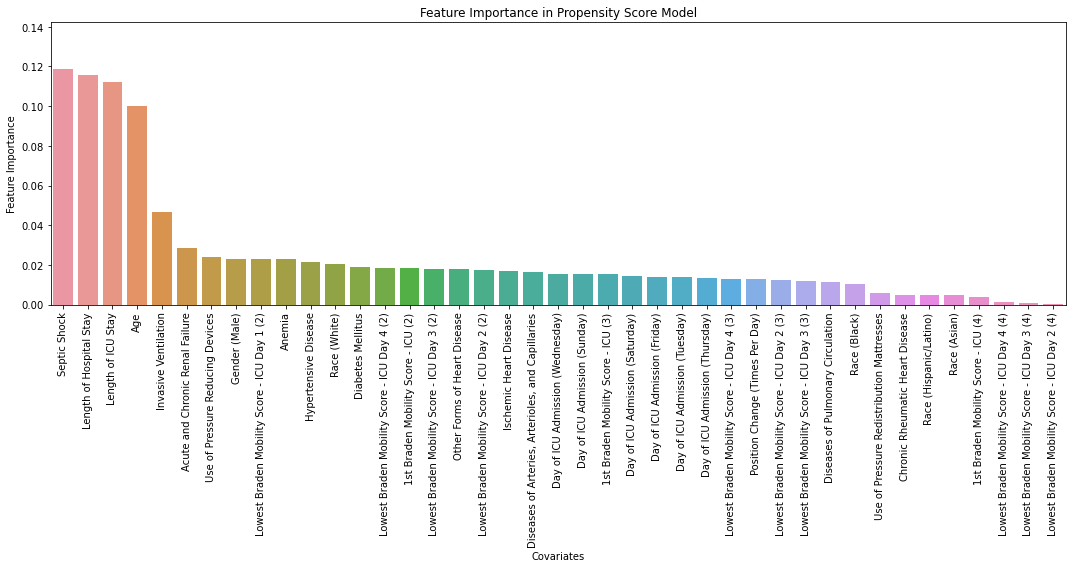

In [6]:
# Results DataFrame
coefficients = pd.DataFrame(columns=["Model", "Code", "Covariate", "Importance"])

# Generate the Propensity Score Model
X = df[covariates].drop("i_vpu", axis=1)
Y = df["Cohort"]=="CASE"

# Train-Test Split
X_trng, X_test, Y_trng, Y_test = train_test_split(X, Y, test_size=0.30, random_state=5104)

# Train model with Adaptive Boosting
PSmod = RandomForestClassifier()
PSmod = AdaBoostClassifier(PSmod, n_estimators=100, random_state=5104, learning_rate=1)
PSmod = PSmod.fit(X_trng, Y_trng)

# Apply model to test data
Y_pred = PSmod.predict(X_test)

# Save Coefficients
c_result = pd.DataFrame({"Model": "Propensity Score",
                         "Code": X.columns.values,
                         "Covariate": "",
                         "Importance": PSmod.feature_importances_
                        }, index=np.arange(X.shape[1]))
for code in c_result.Code:
    c_result.loc[c_result.Code==code, "Covariate"] = descriptions[code]

coefficients = pd.concat([coefficients, c_result]).reset_index(drop=True)
coefficients = coefficients.sort_values("Importance", ascending=False)


# Plot Feature Importances
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=coefficients, y="Importance", x="Covariate") 
plt.ylim(0, coefficients.Importance.max() * 1.2)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.xlabel("Covariates")
plt.title("Feature Importance in Propensity Score Model")
plt.tight_layout()
plt.savefig("PropensityScore_FeatureImportance.png") 


### Calculate Propensity Scores

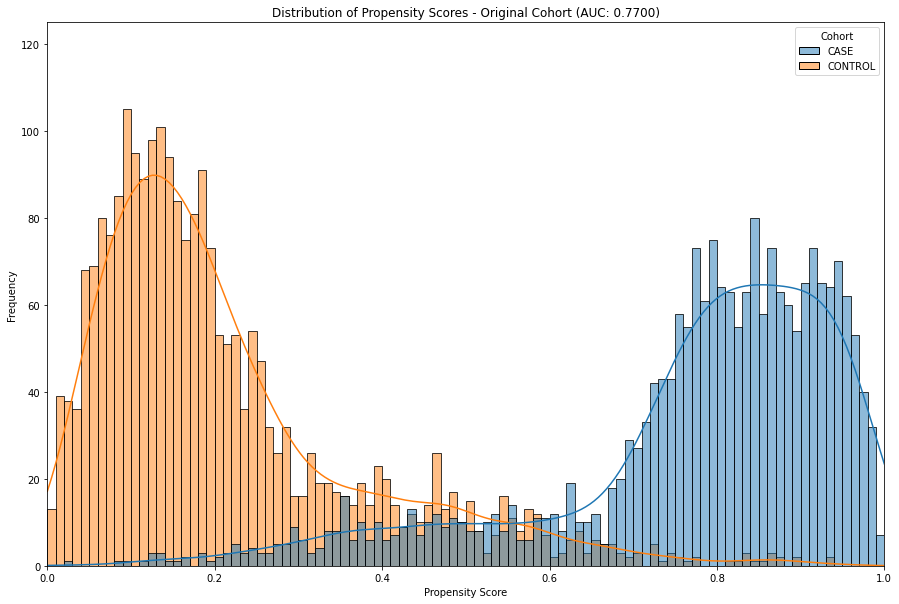

In [7]:
# Evaluate
auc = roc_auc_score(Y_test, PSmod.predict_proba(X_test)[:,1])
auc = "(AUC: {:0.4f})".format(auc)

# Function for calculating logit
def logit(prob_1):
    if prob_1 == 1:
        return float("inf")
    elif prob_1 == 0:
        return -float("inf")
    else:
        return ma.log(prob_1 / (1 - prob_1))

    
# Propensity Score
proability = PSmod.predict_proba(X)
df["PS"] = proability[:,1]
df["PS_Logit"] = df.PS.apply(lambda x: logit(x))

# Sort
mean_ps = np.mean(df.PS)
df["dist_from_ps_mean"] = abs(df.PS - mean_ps)
df = df.sort_values("dist_from_ps_mean", ascending=False).reset_index()
df = df.drop("dist_from_ps_mean", axis=1)


# Plot histogram
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x="PS", hue="Cohort", 
             binwidth=0.01, kde=True) 
plt.ylim(0, 125)
plt.xlim(0, 1)
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Propensity Scores - Original Cohort " + auc)

plt.savefig("PropensityScore_Original.png") 


### Perform Patient Matching

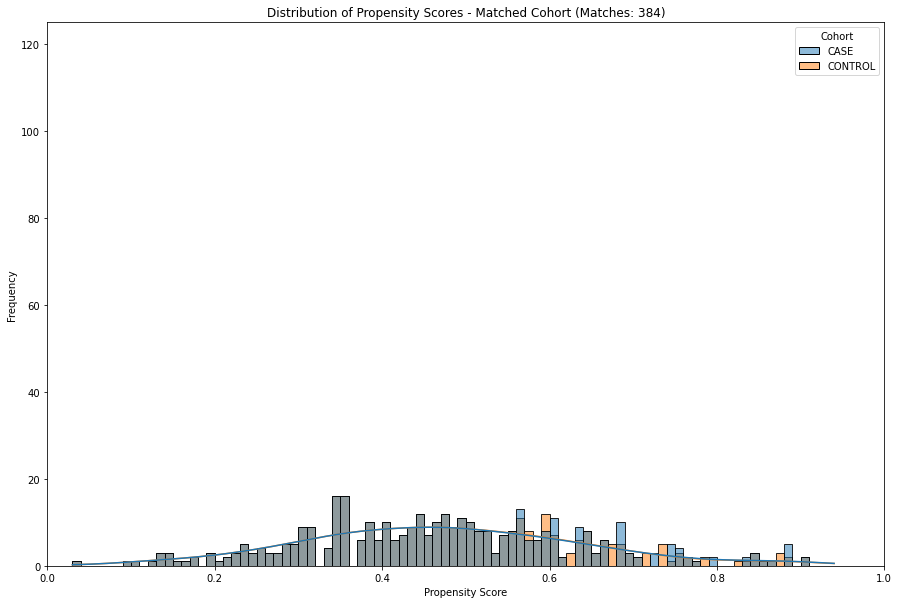

In [8]:
# Find nearest observations
caliper = 0.01
NNgb = NearestNeighbors(radius=caliper)
NNgb.fit(df[["PS"]])
NNgb_dist, NNgb_idx = NNgb.radius_neighbors(df[["PS"]], sort_results=True)


# Perform Matching
df["PS_Matched"] = False
df["PS_MatchIdx"] = np.nan
match_idx = 0

for idx_self, row in df.iterrows():  
    if row.Cohort == "CASE":
        for idx_ngb in NNgb_idx[idx_self]: 
            if (idx_self != idx_ngb) and (df.loc[idx_ngb, "Cohort"] == "CONTROL"):
                if ~df.loc[idx_ngb, "PS_Matched"]:
                    df.loc[idx_self, "PS_Matched"] = True
                    df.loc[idx_self, "PS_MatchIdx"] = match_idx
                    df.loc[idx_ngb, "PS_Matched"] = True
                    df.loc[idx_ngb, "PS_MatchIdx"] = match_idx
                    match_idx = match_idx + 1
                    break
                    
# Get Matched
matched = "(Matches: {})".format(int(df.PS_MatchIdx.max() + 1))

# Plot histogram
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df.loc[df.PS_Matched,:], x="PS", hue="Cohort", 
             binwidth=0.01, kde=True) 
plt.ylim(0, 125)
plt.xlim(0, 1)
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Propensity Scores - Matched Cohort " + matched)

plt.savefig("PropensityScore_Matched.png")


### Calculate Inverse Probabilities of Treatment (IPT) Weights

In [9]:
df["IPTWeight"] = 0
for i in range(0, df.shape[0]):
    cohort = df.Cohort[i]
    pscore = df.PS[i]

    if cohort == "CASE":
        df.loc[i, "IPTWeight"] = 1 / pscore
    elif cohort == "CONTROL":
        df.loc[i, "IPTWeight"] = 1 / (1 - pscore)


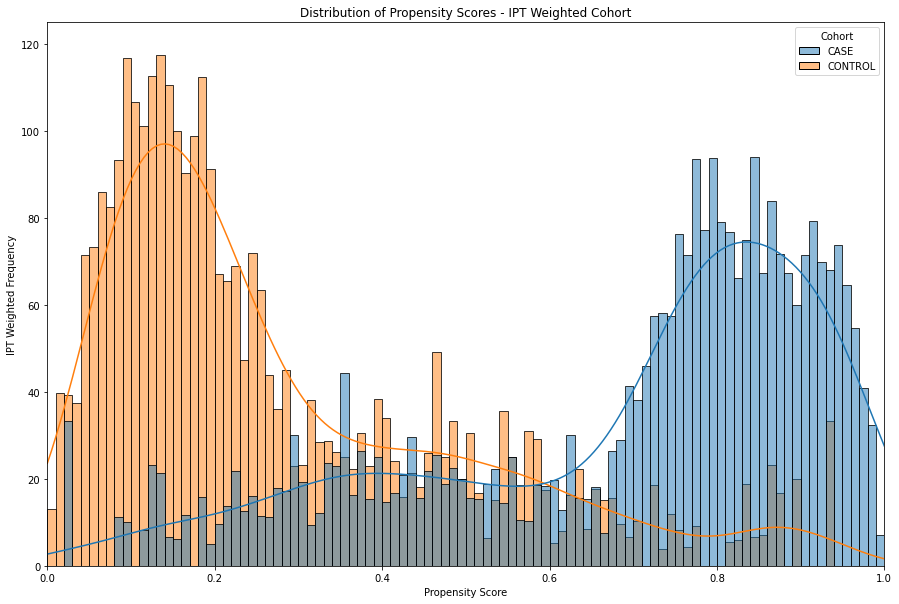

In [10]:
# Plot histogram
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x="PS", hue="Cohort", 
             binwidth=0.01, kde=True, weights="IPTWeight") 
plt.ylim(0, 125)
plt.xlim(0, 1)
plt.xlabel("Propensity Score")
plt.ylabel("IPT Weighted Frequency")
plt.title("Distribution of Propensity Scores - IPT Weighted Cohort")

plt.savefig("PropensityScore_IPTWeighted.png")


In [11]:
# DataFrame with PScores, Match Indexes and IPTWeights
df.to_csv("Data_PSM_PSIPTW.csv")
df

,index,p_fcu,p_age,p_bm1,i_vpu,i_pch,i_prd,i_prm,c_age,c_hls,...,o_ems_0,o_ems_1,o_ems_2,o_ems_3,o_ems_Unknown,PS,PS_Logit,PS_Matched,PS_MatchIdx,IPTWeight
0,596,Surgical Intensive Care Unit (SICU),67,1,1.0,0.0,1.0,0.0,67.0,38.843750,...,0.0,1.0,0.0,0.0,0.0,1.00,36.043653,False,NaN,1.000000
1,4205,Medical Intensive Care Unit (MICU),76,1,1.0,0.0,1.0,0.0,76.0,16.161806,...,1.0,0.0,0.0,0.0,0.0,1.00,36.043653,False,NaN,1.000000
2,2710,Medical Intensive Care Unit (MICU),68,2,1.0,0.0,1.0,0.0,68.0,19.020833,...,1.0,0.0,0.0,0.0,0.0,1.00,36.043653,False,NaN,1.000000
3,4410,Trauma SICU (TSICU),65,1,1.0,0.0,1.0,0.0,65.0,4.886111,...,1.0,0.0,0.0,0.0,0.0,1.00,36.043653,False,NaN,1.000000
4,1936,Trauma SICU (TSICU),79,1,1.0,0.0,0.0,0.0,79.0,19.845139,...,1.0,0.0,0.0,0.0,0.0,1.00,36.043653,False,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,293,Surgical Intensive Care Unit (SICU),34,2,0.0,0.0,1.0,0.0,34.0,14.634028,...,1.0,0.0,0.0,0.0,0.0,0.48,-0.080043,True,379.0,1.923077
4532,4433,Medical Intensive Care Unit (MICU),59,2,0.0,0.0,1.0,0.0,59.0,6.242361,...,1.0,0.0,0.0,0.0,0.0,0.48,-0.080043,True,378.0,1.923077
4533,1078,Medical Intensive Care Unit (MICU),66,2,1.0,0.0,0.0,0.0,66.0,9.057639,...,1.0,0.0,0.0,0.0,0.0,0.48,-0.080043,True,383.0,2.083333
4534,1858,Medical/Surgical Intensive Care Unit (MICU/SICU),74,2,0.0,0.0,1.0,1.0,74.0,10.968056,...,1.0,0.0,0.0,0.0,0.0,0.48,-0.080043,True,376.0,1.923077


# ====================================

## Table 1

# ====================================

In [12]:
# Results DataFrame
table1 = pd.DataFrame(columns=["Code", "Covariate",
                               "O_CASE", "O_CTRL", "O_SSMD", "O_PVal",
                               "P_CASE", "P_CTRL", "P_SSMD", "P_PVal",
                               "M_CASE", "M_CTRL", "M_SSMD", "M_PVal"])
# Functions for SSMD
def cohen_d(ctrl, case):
    
    n_ctrl = len(ctrl)
    n_case = len(case)
    var_ctrl = np.var(ctrl, ddof=1)
    var_case = np.var(case, ddof=1)
    mean_ctrl = np.mean(ctrl)
    mean_case = np.mean(case)
    
    stddev_num = ((n_ctrl - 1) * var_ctrl) + ((n_case - 1) * var_case)
    stddev_dem = n_ctrl + n_case - 2
    stddev = ma.sqrt(stddev_num / stddev_dem)

    return (abs((mean_ctrl - mean_case) / stddev))


def cohen_d_pseudo(vf_ctrl, vf_case, covr):

    n_ctrl = vf_ctrl.shape[0]
    n_case = vf_case.shape[0]

    vf_ctrl["Weighted_Value"] = vf_ctrl[covr] * vf_ctrl["IPTWeight"]
    mean_ctrl = vf_ctrl["Weighted_Value"].sum() / vf_ctrl["IPTWeight"].sum()

    vf_ctrl["Weighted_Squares"] = ((vf_ctrl[covr] - mean_ctrl) ** 2) * vf_ctrl["IPTWeight"]
    var_ctrl = vf_ctrl["Weighted_Squares"].sum() / (n_ctrl - 1)

    vf_case["Weighted_Value"] = vf_case[covr] * vf_case["IPTWeight"]
    mean_case = vf_case["Weighted_Value"].sum() / vf_case["IPTWeight"].sum()

    vf_case["Weighted_Squares"] = ((vf_case[covr] - mean_case) ** 2) * vf_case["IPTWeight"]
    var_case = vf_case["Weighted_Squares"].sum() / (n_case - 1)


    stddev_num = ((n_ctrl - 1) * var_ctrl) + ((n_case - 1) * var_case)
    stddev_dem = n_ctrl + n_case - 2
    stddev = ma.sqrt(stddev_num / stddev_dem)

    return (abs((mean_ctrl - mean_case) / stddev))


def cohen_h(ctrl_mean, case_mean):
    
    p_ctrl = ma.sqrt(ctrl_mean)
    p_case = ma.sqrt(case_mean)
    a_ctrl = 2 * np.arcsin(p_ctrl)
    a_case = 2 * np.arcsin(p_case)

    return (abs(a_ctrl - a_case))


# Function for Weighted Median, IQR and Prevalence
def Weighted_Median_IQR(vf, covr):

    vf = vf.sort_values(covr, ascending=True).reset_index()
    vf["CUMWeight"] = vf.IPTWeight.cumsum()

    total_weight = vf.CUMWeight.iloc[-1]
    total_weight_25 = total_weight * 0.25
    total_weight_50 = total_weight * 0.50
    total_weight_75 = total_weight * 0.75

    v25 = vf.loc[vf.CUMWeight >= total_weight_25, [covr, "CUMWeight"]].reset_index()
    v50 = vf.loc[vf.CUMWeight >= total_weight_50, [covr, "CUMWeight"]].reset_index()
    v75 = vf.loc[vf.CUMWeight >= total_weight_75, [covr, "CUMWeight"]].reset_index()

    median = v50.loc[0, covr]
    iqrrge = v75.loc[0, covr] - v25.loc[0, covr]

    return(median, iqrrge)


def Weighted_Prevalence(vf, covr):

    vf["Weighted_True"] = vf[covr] * vf["IPTWeight"]

    return (vf["Weighted_True"].sum() / vf["IPTWeight"].sum())


def Pseudo_PValue(vf_ctrl, vf_case, covr):

    vf_ctrl = df_ctrl[[covr, "IPTWeight"]]
    vf_case = df_case[[covr, "IPTWeight"]]

    n_ctrl = vf_ctrl.shape[0]
    n_case = vf_case.shape[0]
    
    v_ctrl = vf_ctrl[covr]
    v_case = vf_case[covr]
    
    w_ctrl = vf_ctrl["IPTWeight"]
    w_case = vf_case["IPTWeight"]
    
    m_ctrl = np.average(v_ctrl, weights=w_ctrl)
    m_case = np.average(v_case, weights=w_case)

    var_ctrl = np.average((v_ctrl - m_ctrl) ** 2, weights=w_ctrl)
    var_case = np.average((v_case - m_case) ** 2, weights=w_case)

    t_statistic = (m_ctrl - m_case) / np.sqrt((var_ctrl / n_ctrl) + (var_case / n_case))


    df_num = ((var_ctrl / n_ctrl) + (var_case / n_case)) ** 2 
    df_dem = ((var_ctrl ** 2) / (n_ctrl * (n_ctrl - 1))) + ((var_case ** 2) / (n_case * (n_case - 1)))
    df = df_num / df_dem

    # Calculate p-value
    p_value = 2 * (1 - t.cdf(abs(t_statistic), df))

    return (p_value)


In [13]:
# Control
df_ctrl = df[df.Cohort=="CONTROL"]
df_ctrl_matched = df_ctrl.loc[df.PS_MatchIdx>=0, ]
df_ctrl_matched = df_ctrl_matched.sort_values("PS_MatchIdx")

# Case
df_case = df[df.Cohort=="CASE"]
df_case_matched = df_case.loc[df.PS_MatchIdx>=0, ]
df_case_matched = df_case_matched.sort_values("PS_MatchIdx")

# Generate Table 1
for covr in df.columns.values: 

    if covr == "i_vpu": 
        continue
        
    if covr.startswith("i_") or covr.startswith("c_") or covr.startswith("o_"):
        covr_ctrl_o = df_ctrl[covr]
        covr_case_o = df_case[covr]
        covr_ctrl_p = df_ctrl[[covr, "IPTWeight"]]
        covr_case_p = df_case[[covr, "IPTWeight"]]
        covr_ctrl_m = df_ctrl_matched[covr]
        covr_case_m = df_case_matched[covr]

        if covr not in covariates_cont:
            
            mean_ctrl_o = covr_ctrl_o.mean()
            mean_case_o = covr_case_o.mean()
            mean_ctrl_p = Weighted_Prevalence(covr_ctrl_p, covr)
            mean_case_p = Weighted_Prevalence(covr_case_p, covr)
            mean_ctrl_m = covr_ctrl_m.mean()
            mean_case_m = covr_case_m.mean()
            
            o_ctrl = "{:.2f}%".format(mean_ctrl_o * 100)
            o_case = "{:.2f}%".format(mean_case_o * 100)
            p_ctrl = "{:.2f}%".format(mean_ctrl_p * 100)
            p_case = "{:.2f}%".format(mean_case_p * 100)
            m_ctrl = "{:.2f}%".format(mean_ctrl_m * 100)
            m_case = "{:.2f}%".format(mean_case_m * 100)

            o_ssmd = cohen_h(mean_ctrl_o, mean_case_o)
            p_ssmd = cohen_h(mean_ctrl_p, mean_case_p)
            m_ssmd = cohen_h(mean_ctrl_m, mean_case_m)

            _, o_pval = stats.ranksums(covr_ctrl_o, covr_case_o)
            p_pval = Pseudo_PValue(covr_ctrl_p, covr_case_p, covr)
            _, m_pval = stats.ttest_rel(covr_ctrl_m, covr_case_m) 

        else:

            ctrl_o_median = covr_ctrl_o.median()
            ctrl_o_iqr = covr_ctrl_o.quantile(0.75) - covr_ctrl_o.quantile(0.25)
            o_ctrl = "{:.2f} ({:.2f})".format(ctrl_o_median, ctrl_o_iqr)

            case_o_median = covr_case_o.median()
            case_o_iqr = covr_case_o.quantile(0.75) - covr_case_o.quantile(0.25)
            o_case = "{:.2f} ({:.2f})".format(case_o_median, case_o_iqr)

            ctrl_p_median, ctrl_p_iqr = Weighted_Median_IQR(covr_ctrl_p, covr)
            p_ctrl = "{:.2f} ({:.2f})".format(ctrl_p_median, ctrl_p_iqr)
            
            case_p_median, case_p_iqr = Weighted_Median_IQR(covr_case_p, covr)
            p_case = "{:.2f} ({:.2f})".format(case_p_median, case_p_iqr)
            
            ctrl_m_median = covr_ctrl_m.median()
            ctrl_m_iqr = covr_ctrl_m.quantile(0.75) - covr_ctrl_m.quantile(0.25)
            m_ctrl = "{:.2f} ({:.2f})".format(ctrl_m_median, ctrl_m_iqr)

            case_m_median = covr_case_m.median()
            case_m_iqr = covr_case_m.quantile(0.75) - covr_case_m.quantile(0.25)
            m_case = "{:.2f} ({:.2f})".format(case_m_median, case_m_iqr)

            o_ssmd = cohen_d(covr_ctrl_o, covr_case_o)
            p_ssmd = cohen_d_pseudo(covr_ctrl_p, covr_case_p, covr)
            m_ssmd = cohen_d(covr_ctrl_o, covr_case_o)

            _, o_pval = stats.ranksums(covr_ctrl_o, covr_case_o)
            p_pval = Pseudo_PValue(covr_ctrl_p, covr_case_p, covr)
            _, m_pval = stats.ttest_rel(covr_ctrl_m, covr_case_m) 

        t_result = pd.DataFrame({"Code": covr, 
                                 "Covariate": descriptions[covr],
                                 "O_CASE": o_case, 
                                 "O_CTRL": o_ctrl, 
                                 "O_SSMD": o_ssmd, 
                                 "O_PVal": o_pval,
                                 "P_CASE": p_case, 
                                 "P_CTRL": p_ctrl, 
                                 "P_SSMD": p_ssmd, 
                                 "P_PVal": p_pval,
                                 "M_CASE": m_case, 
                                 "M_CTRL": m_ctrl, 
                                 "M_SSMD": m_ssmd, 
                                 "M_PVal": m_pval
                                }, index=[0])
        table1 = pd.concat([table1, t_result]).reset_index(drop=True)

        
with pd.ExcelWriter("Results_Table1.xlsx") as writer:  
    table1.to_excel(writer, sheet_name="Table_1")
    missing_pct.to_excel(writer, sheet_name="Missing_Pct")


# ====================================

## Modelling, Sensitivity and Sub-Group Analyses

# ====================================

### Model Functions

In [14]:
def PS_Patient_Matching(data, outcome):
    
    data_matched = data.loc[data.PS_MatchIdx>=0, ["Cohort", "PS_MatchIdx", outcome]]
    data_matched = data_matched.sort_values("PS_MatchIdx")

    # Control
    data_ctrl = data_matched[data_matched.Cohort=="CONTROL"]
    data_ctrl = data_ctrl.reset_index()
    data_ctrl["CTRL"] = data_ctrl[outcome]

    # Case
    data_case = data_matched[data_matched.Cohort=="CASE"]
    data_case = data_case.reset_index()
    data_case["CASE"] = data_case[outcome]

    # 2 By 2 Contingency Table
    ps_crosstab = pd.crosstab(data_case["CASE"], data_ctrl["CTRL"], margins=False) 
    
    # Results
    try:
        case1_ctrl0 = ps_crosstab[0][1]
        case0_ctrl1 = ps_crosstab[1][0]
        oddr = case1_ctrl0 / case0_ctrl1
        lowb = ma.exp(np.log(oddr) - 
                         (norm.ppf(0.975) * ma.sqrt((1 / case1_ctrl0) + (1 / case0_ctrl1))))
        uppb = ma.exp(np.log(oddr) + 
                     (norm.ppf(0.975) * ma.sqrt((1 / case1_ctrl0) + (1 / case0_ctrl1))))
    except:
        case1_ctrl0 = 0
        case0_ctrl1 = 0
        oddr = np.nan
        lowb = np.nan
        uppb = np.nan
    
    pval = mcnemar(ps_crosstab, exact=False, correction=True).pvalue
    
    #print("========= " + outcome + " =========")
    #print(ps_crosstab)
    #print("OR: {} / {} = {:.4f}".format(case1_ctrl0, case0_ctrl1, oddr))
    #print("=========================")
    return (oddr, lowb, uppb, pval)


In [15]:
def Multivariate_Regression(data, outcome):
    
    data = sm.add_constant(data)

    model = sm.Logit(outcome, data)
    model = model.fit(maxiter=1000, disp=0, method="lbfgs")

    # Calculate odds ratio
    oddr = np.exp(model.params["i_vpu"])
    conf = model.conf_int()
    lowb = np.exp(conf.loc["i_vpu", 0])
    uppb = np.exp(conf.loc["i_vpu", 1])
    pval = model.pvalues["i_vpu"]

    return (oddr, lowb, uppb, pval)


In [16]:
def PS_IPTW(data, outcome, weight):
    
    data = sm.add_constant(data)

    model = sm.Logit(outcome, data)
    model = model.fit(sample_weight=weight, maxiter=100, 
                      disp=0, method="bfgs")

    # Calculate odds ratio
    oddr = np.exp(model.params["i_vpu"])
    conf = model.conf_int()
    lowb = np.exp(conf.loc["i_vpu", 0])
    uppb = np.exp(conf.loc["i_vpu", 1])
    pval = model.pvalues["i_vpu"]

    return (oddr, lowb, uppb, pval)


### Results DataFrame

In [17]:
# Results DataFrame
odds_ratios = pd.DataFrame(columns=["Model", "Data", "Covariates", 
                                    "Sensitivity", "Subgroup", 
                                    "Outcome", "P_Value", "Odds_Ratio", 
                                    "Lower_Bound_95pct", "Upper_Bound_95pct"])


### -----------------------------------------------

### Run Models

#### Propensity Score Patient Matching Model

In [18]:
df_matched = df[df.PS_MatchIdx>=0]

for outcome in outcomes:
    
    oddr, lowb, uppb, pval = PS_Patient_Matching(df_matched, outcome)

    # Save Results
    result = pd.DataFrame({"Model": "PS Patient Matching",
                           "Data": "Matched",
                           "Covariates": "All", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

    del oddr, lowb, uppb, pval

del df_matched


#### Multivariate Logistic Regression

In [19]:
df_covariates = df.loc[:, covariates]

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

    # Save Results
    result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval
    
del df_covariates
    

#### Propensity Score IPT Weighted Logistic Regression

In [20]:
df_covariates = df.loc[:, "i_vpu"]
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del df_covariates, df_weight


#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [21]:
df_covariates = df.loc[:, covariates]
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del df_covariates, df_weight     


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (Matched)

In [22]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

df_covariates = df.loc[:, covr_unbal]
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "Unbalanced (Matched)", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del covr_unbal, df_covariates, df_weight    


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (IPT Weighted)

In [23]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

df_covariates = df.loc[:, covr_unbal]
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "Unbalanced (IPT Weighted)", 
                           "Sensitivity": "NA",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del covr_unbal, df_covariates, df_weight    


### -----------------------------------------------

### Sensitivity Analysis - Omission of Additional Interventions

#### Multivariate Logistic Regression

In [24]:
df_covariates = df.loc[:, covariates].drop(["i_pch", "i_prd", "i_prm"], axis=1)

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

    # Save Results
    result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "Omission of Additional Interventions",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval
    
del df_covariates
    

#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [25]:
df_covariates = df.loc[:, covariates].drop(["i_pch", "i_prd", "i_prm"], axis=1)
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "Omission of Additional Interventions",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del df_covariates, df_weight     


### Sensitivity Analysis - Omission of Mobility Measures

#### Multivariate Logistic Regression

In [26]:
df_covariates = df.loc[:, covariates].drop(["c_bf1_2", "c_bf1_3", "c_bf1_4", "c_bm1_2", 
                                            "c_bm2_2", "c_bm2_3", "c_bm2_4", "c_bm3_2",
                                            "c_bm3_3", "c_bm3_4", "c_bm4_2", "c_bm4_3", 
                                            "c_bm4_4"], axis=1)

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

    # Save Results
    result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "Omission of Mobility Measures",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval
    
del df_covariates
    

#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [27]:
df_covariates = df.loc[:, covariates].drop(["c_bf1_2", "c_bf1_3", "c_bf1_4", "c_bm1_2",
                                            "c_bm2_2", "c_bm2_3", "c_bm2_4", "c_bm3_2", 
                                            "c_bm3_3", "c_bm3_4", "c_bm4_2", "c_bm4_3",
                                            "c_bm4_4"], axis=1)
df_weight = df.IPTWeight

for outcome in outcomes:
    
    df_outcome = df.loc[:, outcome]
    
    oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

    # Save Results
    result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                           "Data": "Original",
                           "Covariates": "All", 
                           "Sensitivity": "Omission of Mobility Measures",
                           "Subgroup": "NA",
                           "Outcome": outcome, 
                           "P_Value": pval, 
                           "Odds_Ratio": oddr,
                           "Lower_Bound_95pct": lowb, 
                           "Upper_Bound_95pct": uppb
                          }, index=[0])
    odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)
    
    del df_outcome, oddr, lowb, uppb, pval

del df_covariates, df_weight     


### -----------------------------------------------

### Sub-Group Analysis - First Care Unit

In [28]:
MSICU = ["Medical Intensive Care Unit (MICU)", "Surgical Intensive Care Unit (SICU)",
         "Medical/Surgical Intensive Care Unit (MICU/SICU)"]
TSICU = ["Trauma SICU (TSICU)"]

#### Multivariate Logistic Regression

In [29]:
for ICU in ["MSICU", "TSICU"]:
    
    if ICU == "MSICU":
        df_sub = df.loc[df["p_fcu"].isin(MSICU), :].reset_index()
    elif ICU == "TSICU":
        df_sub = df.loc[df["p_fcu"].isin(TSICU), :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates]

    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

        # Save Results
        result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": ICU,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del ICU


#### Propensity Score IPT Weighted Logistic Regression

In [30]:
for ICU in ["MSICU", "TSICU"]:
    
    if ICU == "MSICU":
        df_sub = df.loc[df["p_fcu"].isin(MSICU), :].reset_index()
    elif ICU == "TSICU":
        df_sub = df.loc[df["p_fcu"].isin(TSICU), :].reset_index()
    
    df_covariates = df_sub.loc[:, "i_vpu"]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": ICU,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del ICU


#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [31]:
for ICU in ["MSICU", "TSICU"]:
    
    if ICU == "MSICU":
        df_sub = df.loc[df["p_fcu"].isin(MSICU), :].reset_index()
    elif ICU == "TSICU":
        df_sub = df.loc[df["p_fcu"].isin(TSICU), :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": ICU,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del ICU


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (Matched)

In [32]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for ICU in ["MSICU", "TSICU"]:
    
    if ICU == "MSICU":
        df_sub = df.loc[df["p_fcu"].isin(MSICU), :].reset_index()
    elif ICU == "TSICU":
        df_sub = df.loc[df["p_fcu"].isin(TSICU), :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (Matched)", 
                               "Sensitivity": "NA",
                               "Subgroup": ICU,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del ICU, covr_unbal
  


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (IPT Weighted)

In [33]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for ICU in ["MSICU", "TSICU"]:
    
    if ICU == "MSICU":
        df_sub = df.loc[df["p_fcu"].isin(MSICU), :].reset_index()
    elif ICU == "TSICU":
        df_sub = df.loc[df["p_fcu"].isin(TSICU), :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (IPT Weighted)", 
                               "Sensitivity": "NA",
                               "Subgroup": ICU,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del ICU, covr_unbal
  


### Sub-Group Analysis - Age Group

In [34]:
cutoff_age = 60

#### Multivariate Logistic Regression

In [35]:
for AGE in ["Below " + str(cutoff_age) + "yo", str(cutoff_age) + "yo and Above"]:
    
    if "Below" in AGE:
        df_sub = df.loc[df["p_age"] < cutoff_age, :].reset_index()
    elif "Above" in AGE:
        df_sub = df.loc[df["p_age"] >= cutoff_age, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates]

    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

        # Save Results
        result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": AGE,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del AGE


#### Propensity Score IPT Weighted Logistic Regression

In [36]:
for AGE in ["Below " + str(cutoff_age) + "yo", str(cutoff_age) + "yo and Above"]:
    
    if "Below" in AGE:
        df_sub = df.loc[df["p_age"] < cutoff_age, :].reset_index()
    elif "Above" in AGE:
        df_sub = df.loc[df["p_age"] >= cutoff_age, :].reset_index()
    
    df_covariates = df_sub.loc[:, "i_vpu"]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": AGE,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del AGE


#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [37]:
for AGE in ["Below " + str(cutoff_age) + "yo", str(cutoff_age) + "yo and Above"]:
    
    if "Below" in AGE:
        df_sub = df.loc[df["p_age"] < cutoff_age, :].reset_index()
    elif "Above" in AGE:
        df_sub = df.loc[df["p_age"] >= cutoff_age, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": AGE,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del AGE


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (Matched)

In [38]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for AGE in ["Below " + str(cutoff_age) + "yo", str(cutoff_age) + "yo and Above"]:
    
    if "Below" in AGE:
        df_sub = df.loc[df["p_age"] < cutoff_age, :].reset_index()
    elif "Above" in AGE:
        df_sub = df.loc[df["p_age"] >= cutoff_age, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (Matched)", 
                               "Sensitivity": "NA",
                               "Subgroup": AGE,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del AGE, covr_unbal


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (IPT Weighted)

In [39]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for AGE in ["Below " + str(cutoff_age) + "yo", str(cutoff_age) + "yo and Above"]:
    
    if "Below" in AGE:
        df_sub = df.loc[df["p_age"] < cutoff_age, :].reset_index()
    elif "Above" in AGE:
        df_sub = df.loc[df["p_age"] >= cutoff_age, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (IPT Weighted)", 
                               "Sensitivity": "NA",
                               "Subgroup": AGE,
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del AGE, covr_unbal


### Sub-Group Analysis - Braden Score on first day of ICU Admission

#### Multivariate Logistic Regression

In [40]:
for BSF in [1, 2]:
    
    df_sub = df.loc[df["p_bm1"] == BSF, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates].drop(["c_bm1_2", "c_bf1_2", "c_bf1_3", "c_bf1_4"], axis=1)

    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

        # Save Results
        result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Braden Score " + str(BSF),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del BSF


#### Propensity Score IPT Weighted Logistic Regression

In [41]:
for BSF in [1, 2]:
    
    df_sub = df.loc[df["p_bm1"] == BSF, :].reset_index()
    
    df_covariates = df_sub.loc[:, "i_vpu"]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Braden Score " + str(BSF),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del BSF


#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [42]:
for BSF in [1, 2]:
    
    df_sub = df.loc[df["p_bm1"] == BSF, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates].drop(["c_bm1_2", "c_bf1_2", "c_bf1_3", "c_bf1_4"], axis=1)
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Braden Score " + str(BSF),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del BSF


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (Matched)

In [43]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
covr_bm = ["c_bm1_2", "c_bf1_2", "c_bf1_3", "c_bf1_4"]
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov in covr_bm:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for BSF in [1, 2]:
    
    df_sub = df.loc[df["p_bm1"] == BSF, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (Matched)", 
                               "Sensitivity": "NA",
                               "Subgroup": "Braden Score " + str(BSF),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del BSF, covr_unbal


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (IPT Weighted)

In [44]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
covr_bm = ["c_bm1_2", "c_bf1_2", "c_bf1_3", "c_bf1_4"]
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov in covr_bm:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")
print(covr_unbal)
for BSF in [1, 2]:
    
    df_sub = df.loc[df["p_bm1"] == BSF, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (IPT Weighted)", 
                               "Sensitivity": "NA",
                               "Subgroup": "Braden Score " + str(BSF),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del BSF, covr_unbal


['i_vpu', 'c_imv', 'c_ohd', 'c_rfl', 'c_sps', 'i_prd']


### Sub-Group Analysis - Septic Shock

#### Multivariate Logistic Regression

In [45]:
for SPS in [0, 1]:
    
    df_sub = df.loc[df["c_sps"] == SPS, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates].drop(["c_sps"], axis=1)

    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = Multivariate_Regression(df_covariates, df_outcome)

        # Save Results
        result = pd.DataFrame({"Model": "Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Septic Shock " + str(SPS),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del SPS


#### Propensity Score IPT Weighted Logistic Regression

In [46]:
for SPS in [0, 1]:
    
    df_sub = df.loc[df["c_sps"] == SPS, :].reset_index()
    
    df_covariates = df_sub.loc[:, "i_vpu"]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Septic Shock " + str(SPS),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del SPS


#### Propensity Score IPT Weighted Multivariate Logistic Regression - All Covariates

In [47]:
for SPS in [0, 1]:
    
    df_sub = df.loc[df["c_sps"] == SPS, :].reset_index()
    
    df_covariates = df_sub.loc[:, covariates].drop(["c_sps"], axis=1)
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "All", 
                               "Sensitivity": "NA",
                               "Subgroup": "Septic Shock " + str(SPS),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del SPS


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (Matched)

In [48]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov == "c_sps":
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for SPS in [0, 1]:
    
    df_sub = df.loc[df["c_sps"] == SPS, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (Matched)", 
                               "Sensitivity": "NA",
                               "Subgroup": "Septic Shock " + str(SPS),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del SPS, covr_unbal


#### Propensity Score IPT Weighted Multivariate Logistic Regression - Unbalanced Covariates (IPT Weighted)

In [49]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov == "c_sps":
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")

for SPS in [0, 1]:
    
    df_sub = df.loc[df["c_sps"] == SPS, :].reset_index()
    
    df_covariates = df_sub.loc[:, covr_unbal]
    df_weight = df_sub.IPTWeight
    
    for outcome in outcomes:

        df_outcome = df_sub.loc[:, outcome]

        oddr, lowb, uppb, pval = PS_IPTW(df_covariates, df_outcome, df_weight)

        # Save Results
        result = pd.DataFrame({"Model": "PS IPTW Multivariate Logistic Regression",
                               "Data": "Original",
                               "Covariates": "Unbalanced (IPT Weighted)", 
                               "Sensitivity": "NA",
                               "Subgroup": "Septic Shock " + str(SPS),
                               "Outcome": outcome, 
                               "P_Value": pval, 
                               "Odds_Ratio": oddr,
                               "Lower_Bound_95pct": lowb, 
                               "Upper_Bound_95pct": uppb
                              }, index=[0])
        odds_ratios = pd.concat([odds_ratios, result]).reset_index(drop=True)

        del df_outcome, oddr, lowb, uppb, pval

    del df_sub, df_covariates
    
del SPS, covr_unbal


## Save Results

In [50]:
odds_ratios.to_excel("Results_OddsRatio.xlsx")
odds_ratios

,Model,Data,Covariates,Sensitivity,Subgroup,Outcome,P_Value,Odds_Ratio,Lower_Bound_95pct,Upper_Bound_95pct
0,PS Patient Matching,Matched,All,NA,NA,o_cpu,0.819708,1.081081,0.691360,1.690490
1,PS Patient Matching,Matched,All,NA,NA,o_ext,0.453255,0.600000,0.218068,1.650858
2,PS Patient Matching,Matched,All,NA,NA,o_nxt,0.335504,1.300000,0.807667,2.092447
3,PS Patient Matching,Matched,All,NA,NA,o_eti,0.727724,1.200000,0.604782,2.381024
4,PS Patient Matching,Matched,All,NA,NA,o_ems_1,0.502335,1.500000,0.613158,3.669525
...,...,...,...,...,...,...,...,...,...,...
345,PS IPTW Multivariate Logistic Regression,Original,Unbalanced (IPT Weighted),NA,Septic Shock 1,o_nxt,0.674910,0.900010,0.550102,1.472487
346,PS IPTW Multivariate Logistic Regression,Original,Unbalanced (IPT Weighted),NA,Septic Shock 1,o_eti,0.250648,1.585836,0.722090,3.482776
347,PS IPTW Multivariate Logistic Regression,Original,Unbalanced (IPT Weighted),NA,Septic Shock 1,o_ems_1,0.221939,0.610127,0.276111,1.348208
348,PS IPTW Multivariate Logistic Regression,Original,Unbalanced (IPT Weighted),NA,Septic Shock 1,o_ems_2,0.539785,1.253420,0.608864,2.580316


In [51]:
table1

,Code,Covariate,O_CASE,O_CTRL,O_SSMD,O_PVal,P_CASE,P_CTRL,P_SSMD,P_PVal,M_CASE,M_CTRL,M_SSMD,M_PVal
0,i_pch,Position Change (Times Per Day),0.00 (0.00),0.00 (0.00),0.099251,1.980691e-01,0.00 (0.00),0.00 (0.00),0.044726,0.214302,0.00 (0.00),0.00 (0.00),0.099251,0.053692
1,i_prd,Use of Pressure Reducing Devices,62.65%,46.24%,0.331075,1.221290e-21,58.51%,50.36%,0.163834,0.031401,55.73%,60.94%,0.105698,0.140582
2,i_prm,Use of Pressure Redistribution Mattresses,5.09%,3.09%,0.101614,2.447363e-01,4.47%,3.12%,0.070993,0.147829,4.17%,4.69%,0.025331,0.732085
3,c_age,Age,64.00 (23.00),62.00 (26.00),0.089091,2.601063e-03,65.00 (23.00),61.00 (25.00),0.094432,0.063348,65.00 (23.00),61.00 (26.25),0.089091,0.119176
4,c_hls,Length of Hospital Stay,15.87 (14.44),13.96 (11.92),0.144756,1.203154e-08,15.44 (13.54),14.29 (12.47),0.044367,0.217441,15.47 (12.11),16.60 (15.41),0.144756,0.063551
5,c_ils,Length of ICU Stay,8.15 (7.75),7.07 (6.09),0.183683,3.352486e-13,7.91 (7.59),7.16 (6.56),0.079066,0.089389,7.72 (7.77),8.51 (8.84),0.183683,0.257792
6,c_dms,Diabetes Mellitus,27.22%,26.78%,0.009963,7.967607e-01,26.17%,26.72%,0.012331,0.718716,22.66%,28.12%,0.125810,0.081158
7,c_rhd,Chronic Rheumatic Heart Disease,2.75%,1.34%,0.101725,4.090514e-01,2.59%,1.39%,0.086693,0.117598,3.12%,1.30%,0.126705,0.089579
8,c_htd,Hypertensive Disease,56.21%,59.57%,0.067994,5.064743e-02,56.24%,59.58%,0.067745,0.151027,54.43%,59.90%,0.110574,0.118678
9,c_ihd,Ischemic Heart Disease,25.63%,19.38%,0.149944,2.742399e-04,23.94%,20.18%,0.090832,0.094404,21.35%,21.09%,0.006369,0.928869


In [52]:
covr_unbal = table1.loc[table1.M_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")
covr_unbal

['i_vpu', 'c_bm4_3', 'c_pcd', 'c_rce_BLACK', 'c_rfl', 'c_sps']

In [53]:
covr_unbal = table1.loc[table1.P_PVal < 0.05, "Code"]
covr_unbal = np.unique(covr_unbal).tolist()
for cov in reversed(covr_unbal):
    if cov not in covariates:
        covr_unbal.remove(cov)
    elif cov.startswith("o_"):
        covr_unbal.remove(cov)

covr_unbal.insert(0, "i_vpu")
covr_unbal

['i_vpu', 'c_bm1_2', 'c_imv', 'c_ohd', 'c_rfl', 'c_sps', 'i_prd']